<a href="https://colab.research.google.com/github/Voyageran/Assignments620/blob/main/AMA620.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# AMA620 Assignment 1
---
JIANG Ran \& 23036623R



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.insert(0,"/content/content/notebooks/colabInstallPackage")

!cp -av '/content/gdrive/MyDrive/Colab Notebooks/d2l' '/content/'

Mounted at /content/gdrive
'/content/gdrive/MyDrive/Colab Notebooks/d2l/paddle.py' -> '/content/d2l/paddle.py'
'/content/gdrive/MyDrive/Colab Notebooks/d2l/mxnet.py' -> '/content/d2l/mxnet.py'
'/content/gdrive/MyDrive/Colab Notebooks/d2l/tensorflow.py' -> '/content/d2l/tensorflow.py'
'/content/gdrive/MyDrive/Colab Notebooks/d2l/torch.py' -> '/content/d2l/torch.py'
'/content/gdrive/MyDrive/Colab Notebooks/d2l/__init__.py' -> '/content/d2l/__init__.py'
'/content/gdrive/MyDrive/Colab Notebooks/d2l/__pycache__/mxnet.cpython-310.pyc' -> '/content/d2l/__pycache__/mxnet.cpython-310.pyc'
'/content/gdrive/MyDrive/Colab Notebooks/d2l/__pycache__/__init__.cpython-310.pyc' -> '/content/d2l/__pycache__/__init__.cpython-310.pyc'
'/content/gdrive/MyDrive/Colab Notebooks/d2l/__pycache__/torch.cpython-310.pyc' -> '/content/d2l/__pycache__/torch.cpython-310.pyc'
'/content/gdrive/MyDrive/Colab Notebooks/d2l/__pycache__/tensorflow.cpython-310.pyc' -> '/content/d2l/__pycache__/tensorflow.cpython-310.pyc'
'

In [ ]:
import torch
import torchvision
from d2l import torch as d2l
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

## Preparing the Dataset

In [ ]:
batch_size_train = 100
batch_size_test = 1000

In [ ]:
## Loading data
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/content/gdrive/MyDrive/Colab Notebooks/d2l',train = True, download = True, #'/content/drive/MyDrive/assign1'
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307, ), (0.3081,) #global mean, standard deviation of MNIST
                                   )
                                ]
                                )
                               ),
    batch_size = batch_size_train, shuffle = True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/content/gdrive/MyDrive/Colab Notebooks/d2l',train = True, download = False,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize(
                                       (0.1307, ), (0.3081,) #global mean, standard deviation of MNIST
                                   )
                                ]
                                )
                               ),
    batch_size = batch_size_test, shuffle = True
)

In [ ]:
# next(iter(train_loader))

In [ ]:
# Use test_loader
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [ ]:
# examples = enumerate(test_loader)
# batch_idx, (example_data, example_targets) = next(examples)
# batch_idx

In [ ]:
example_data.shape

torch.Size([1000, 1, 28, 28])

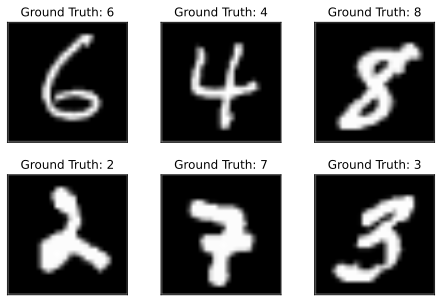

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap = 'gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

# fig

## CNN

### Building the Network

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [ ]:
# instance
network = Net()

In [ ]:
n_epochs = 8
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enable = False
torch.manual_seed(random_seed)

In [ ]:
# initialize optimizer
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum) #learning_rate=0.01,momentum=0.5

### Training the Model

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*100) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
# test()
# keep track of the progress with some printouts
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-301-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.355847
Train Epoch: 1 [1000/60000 (2%)]	Loss: 2.285408
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.267978
Train Epoch: 1 [3000/60000 (5%)]	Loss: 2.265007
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.244080
Train Epoch: 1 [5000/60000 (8%)]	Loss: 2.264297
Train Epoch: 1 [6000/60000 (10%)]	Loss: 2.221968
Train Epoch: 1 [7000/60000 (12%)]	Loss: 2.191390
Train Epoch: 1 [8000/60000 (13%)]	Loss: 2.166354
Train Epoch: 1 [9000/60000 (15%)]	Loss: 2.112631
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.035832
Train Epoch: 1 [11000/60000 (18%)]	Loss: 1.964915
Train Epoch: 1 [12000/60000 (20%)]	Loss: 1.949992
Train Epoch: 1 [13000/60000 (22%)]	Loss: 1.877749
Train Epoch: 1 [14000/60000 (23%)]	Loss: 1.691632
Train Epoch: 1 [15000/60000 (25%)]	Loss: 1.644858
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.576668
Train Epoch: 1 [17000/60000 (28%)]	Loss: 1.389927
Train Epoch: 1 [18000/60000 (30%)]	Loss: 1.443596
Train Epoch: 1 [19000/60000 (32%)]	Loss: 1.311536
Train Epoch: 1 [200

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.2764, Accuracy: 55275/60000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.451749
Train Epoch: 2 [1000/60000 (2%)]	Loss: 0.736380
Train Epoch: 2 [2000/60000 (3%)]	Loss: 0.459200
Train Epoch: 2 [3000/60000 (5%)]	Loss: 0.503279
Train Epoch: 2 [4000/60000 (7%)]	Loss: 0.757079
Train Epoch: 2 [5000/60000 (8%)]	Loss: 0.514530
Train Epoch: 2 [6000/60000 (10%)]	Loss: 0.589051
Train Epoch: 2 [7000/60000 (12%)]	Loss: 0.500261
Train Epoch: 2 [8000/60000 (13%)]	Loss: 0.418052
Train Epoch: 2 [9000/60000 (15%)]	Loss: 0.722626
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.436772
Train Epoch: 2 [11000/60000 (18%)]	Loss: 0.574027
Train Epoch: 2 [12000/60000 (20%)]	Loss: 0.503467
Train Epoch: 2 [13000/60000 (22%)]	Loss: 0.522689
Train Epoch: 2 [14000/60000 (23%)]	Loss: 0.570908
Train Epoch: 2 [15000/60000 (25%)]	Loss: 0.574409
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.462549
Train Epoch: 2 [17000/60000 (28%)]	Loss: 0.650371
Train Epoch: 2 [18000/60000 (30%)]	Loss: 0.435735
Train Epoc

### Evaluating Performance

Text(0, 0.5, 'negative log likelihood loss')

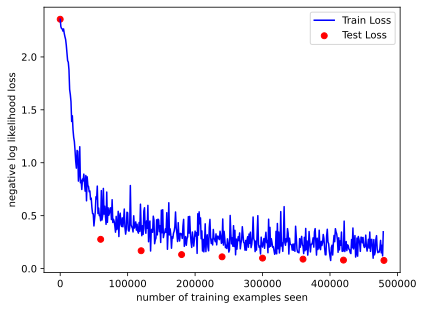

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, [train_losses[0]] + test_losses, color='red')
# plt.plot(test_counter, [train_losses[0]] + test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [ ]:
# len(train_counter), len(train_losses), len(test_counter), len(test_losses)

(480, 480, 8, 8)

In [ ]:
# test_counter = [test_counter[i]+60 for i in range(8)]

In [ ]:
# plot the pictures
with torch.no_grad():
  output = network(example_data)

<ipython-input-269-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


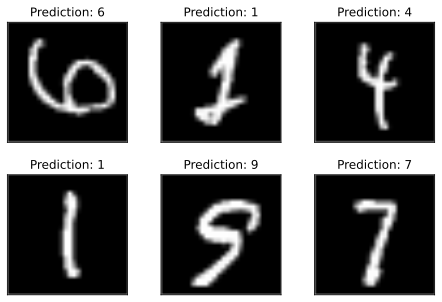

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])

In [ ]:
# plt.imshow(example_data[0],cmap='gray')
len(example_data[2])
example_data.shape

torch.Size([1000, 1, 28, 28])

## FNN

In [ ]:
# FNN
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # activate function
        self.relu = nn.ReLU()
        # Linear function
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(-1)  #flatten
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return F.log_soft(x)

# net = nn.Sequential(
#     nn.Flatten(), nn.Linear(784,100), nn.ReLU(), nn.Linear(100,10)
# )
# def init_weights(m): #each layer
#   if type(m) == nn.Linear:
#     nn.init.normal_(m.weight, std=0.01)
# net.apply(init_weights)

In [ ]:
def trainFNN(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_lossesFNN.append(loss.item())
      train_counterFNN.append(
        (batch_idx*100) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

In [ ]:
def testFNN():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_lossesFNN.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
input_dim = 28*28
hidden_dim = 200
output_dim = 10

fnn = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)
print(fnn)

FeedforwardNeuralNetModel(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=200, out_features=10, bias=True)
)


In [ ]:
train_lossesFNN = []
train_counterFNN = []
test_lossesFNN = []
test_counterFNN = [i*len(train_loader.dataset) for i in range(n_epochs+1)]

In [ ]:
# test()
for epoch in range(1, n_epochs + 1):
  trainFNN(epoch)
  testFNN()

<ipython-input-269-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 0.129271
Train Epoch: 1 [1000/60000 (2%)]	Loss: 0.309862
Train Epoch: 1 [2000/60000 (3%)]	Loss: 0.245563
Train Epoch: 1 [3000/60000 (5%)]	Loss: 0.383568
Train Epoch: 1 [4000/60000 (7%)]	Loss: 0.245501
Train Epoch: 1 [5000/60000 (8%)]	Loss: 0.157846
Train Epoch: 1 [6000/60000 (10%)]	Loss: 0.289762
Train Epoch: 1 [7000/60000 (12%)]	Loss: 0.141522
Train Epoch: 1 [8000/60000 (13%)]	Loss: 0.205348
Train Epoch: 1 [9000/60000 (15%)]	Loss: 0.254697
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.132270
Train Epoch: 1 [11000/60000 (18%)]	Loss: 0.207722
Train Epoch: 1 [12000/60000 (20%)]	Loss: 0.120411
Train Epoch: 1 [13000/60000 (22%)]	Loss: 0.220281
Train Epoch: 1 [14000/60000 (23%)]	Loss: 0.278564
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.142227
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.154397
Train Epoch: 1 [17000/60000 (28%)]	Loss: 0.147732
Train Epoch: 1 [18000/60000 (30%)]	Loss: 0.200576
Train Epoch: 1 [19000/60000 (32%)]	Loss: 0.190272
Train Epoch: 1 [200

In [ ]:
fig = plt.figure()
plt.plot(train_counterFNN, train_lossesFNN, color='blue')
plt.scatter(test_counterFNN, [train_losses[0]] + test_lossesFNN, color='red')
# plt.plot(test_counter, [train_losses[0]] + test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.ylim(0,2.5)

In [ ]:
len(train_losses), len(test_losses),len(train_counter)

(480, 8, 480)

## Visual Transformer

In [ ]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 646.0 kB/s eta 0:00:00


In [343]:
import torch
import torchvision
from torch import nn
import time
import torch
import torch.nn.functional as F
from torch import optim
from torch import nn
from einops import rearrange

In [344]:
#Residual block
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

In [345]:
#layernorm
class PreNorm(nn.Module):
    """layernorm"""
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

In [346]:
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x):
        return self.net(x)

In [347]:
class Attention(nn.Module):
    """multi-attention"""
    def __init__(self, dim, heads=8):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5

        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.to_out = nn.Linear(dim, dim)

    def forward(self, x, mask = None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x)
        q, k, v = rearrange(qkv, 'b n (qkv h d) -> qkv b h n d', qkv=3, h=h)

        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale

        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value = True)
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            mask = mask[:, None, :] * mask[:, :, None]
            dots.masked_fill_(~mask, float('-inf'))
            del mask

        attn = dots.softmax(dim=-1)

        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

In [348]:
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads = heads))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim)))
            ]))

    def forward(self, x, mask=None):
        for attn, ff in self.layers:
            x = attn(x, mask=mask)
            x = ff(x)
        return x

In [349]:
class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels=3):
        super().__init__()
        assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2

        self.patch_size = patch_size

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = Transformer(dim, depth, heads, mlp_dim)

        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, num_classes)
        )

    def forward(self, img, mask=None):
        p = self.patch_size

        x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = p, p2 = p)
        x = self.patch_to_embedding(x)

        cls_tokens = self.cls_token.expand(img.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        x = self.transformer(x, mask)

        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)


In [350]:
BATCH_SIZE_TRAIN = 100
BATCH_SIZE_TEST = 1000

In [351]:
def train_epoch(model, optimizer, data_loader, loss_history):
    total_samples = len(data_loader.dataset)
    model.train()

    for i, (data, target) in enumerate(data_loader):
        optimizer.zero_grad()
        output = F.log_softmax(model(data), dim=1)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_loader)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))
            loss_history.append(loss.item())

In [352]:
def evaluate(model, data_loader, loss_history):
    model.eval()

    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    with torch.no_grad():
        for data, target in data_loader:
            output = F.log_softmax(model(data), dim=1)
            loss = F.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)

            total_loss += loss.item()
            correct_samples += pred.eq(target).sum()

    avg_loss = total_loss / total_samples
    loss_history.append(avg_loss)
    print('\nAverage test loss: ' + '{:.4f}'.format(avg_loss) +
          '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
          '{:5}'.format(total_samples) + ' (' +
          '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)\n')

In [353]:
N_EPOCHS = 8

start_time = time.time()

In [357]:
vTrans = ViT(image_size=28, patch_size=7, num_classes=10, channels=1,
            dim=64, depth=6, heads=8, mlp_dim=128)
optimizer = optim.Adam(vTrans.parameters(), lr=0.003)

In [358]:
train_loss_history, test_loss_history = [], []

for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)
    train_epoch(vTrans, optimizer, train_loader, train_loss_history)
    evaluate(vTrans, test_loader, test_loss_history)

print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')

Epoch: 1
[    0/60000 (  0%)]  Loss: 2.4048
[10000/60000 ( 17%)]  Loss: 0.5506
[20000/60000 ( 33%)]  Loss: 0.2663
[30000/60000 ( 50%)]  Loss: 0.1645
[40000/60000 ( 67%)]  Loss: 0.1470
[50000/60000 ( 83%)]  Loss: 0.0514

Average test loss: 0.1442  Accuracy:57266/60000 (95.44%)

Epoch: 2
[    0/60000 (  0%)]  Loss: 0.1490
[10000/60000 ( 17%)]  Loss: 0.1005
[20000/60000 ( 33%)]  Loss: 0.2516
[30000/60000 ( 50%)]  Loss: 0.1505
[40000/60000 ( 67%)]  Loss: 0.1754
[50000/60000 ( 83%)]  Loss: 0.0678

Average test loss: 0.0805  Accuracy:58499/60000 (97.50%)

Epoch: 3
[    0/60000 (  0%)]  Loss: 0.0549
[10000/60000 ( 17%)]  Loss: 0.2351
[20000/60000 ( 33%)]  Loss: 0.1360
[30000/60000 ( 50%)]  Loss: 0.1057
[40000/60000 ( 67%)]  Loss: 0.1661
[50000/60000 ( 83%)]  Loss: 0.0837

Average test loss: 0.0836  Accuracy:58427/60000 (97.38%)

Epoch: 4
[    0/60000 (  0%)]  Loss: 0.1150
[10000/60000 ( 17%)]  Loss: 0.0405
[20000/60000 ( 33%)]  Loss: 0.0625
[30000/60000 ( 50%)]  Loss: 0.0358
[40000/60000 ( 67

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_loss_history, color='blue')
plt.scatter(test_counter, test_loss_history, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

## Modify

In [376]:
import math, copy, time
import numpy as np

In [378]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class LayerNorm(nn.Module):
    "Construct a layernorm module."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))


class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        d_ff = d_model * 4
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))


def attention(query, key, value, mask=None, dropout=None):
    """
        Compute 'Scaled Dot Product Attention'
        query, key, value : batch_size, n_head, seq_len, dim of space
    """

    d_k = query.size(-1)
    # scores: batch_size, n_head, seq_len, seq_len
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)

    if mask is not None:
        scores = scores.masked_fill(mask==0, -1e9)


    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn


class MHPooling(nn.Module):
    def __init__(self, d_model, h, dropout=0.1):
        "Take in model size and number of heads."
        super(MHPooling, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

        #auto-regressive
        attn_shape = (1, 3000, 3000)
        subsequent_mask =  np.triu(np.ones(attn_shape), k=1).astype('uint8')
        self.mask = (torch.from_numpy(subsequent_mask) == 0).unsqueeze(1).cuda()

    def forward(self, x):
        "Implements Figure 2"

        nbatches, seq_len, d_model = x.shape

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (x, x, x))]

        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(query, key, value, mask=self.mask[:,:, :seq_len, :seq_len],
                                 dropout=self.dropout)

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

class LocalRNN(nn.Module):
    def __init__(self, input_dim, output_dim, rnn_type, ksize, dropout):
        super(LocalRNN, self).__init__()
        """
        LocalRNN structure
        """
        self.ksize = ksize
        if rnn_type == 'GRU':
            self.rnn = nn.GRU(output_dim, output_dim, batch_first=True)
        elif rnn_type == 'LSTM':
            self.rnn = nn.LSTM(output_dim, output_dim, batch_first=True)
        else:
            self.rnn = nn.RNN(output_dim, output_dim, batch_first=True)

        self.output = nn.Sequential(nn.Linear(output_dim, output_dim), nn.ReLU())

        # To speed up
        idx = [i for j in range(self.ksize-1,10000,1) for i in range(j-(self.ksize-1),j+1,1)]
        self.select_index = torch.LongTensor(idx).cuda()
        self.zeros = torch.zeros((self.ksize-1, input_dim)).cuda()

    def forward(self, x):
        nbatches, l, input_dim = x.shape
        x = self.get_K(x) # b x seq_len x ksize x d_model
        batch, l, ksize, d_model = x.shape
        h = self.rnn(x.view(-1, self.ksize, d_model))[0][:,-1,:]
        return h.view(batch, l, d_model)

    def get_K(self, x):
        batch_size, l, d_model = x.shape
        zeros = self.zeros.unsqueeze(0).repeat(batch_size, 1, 1)
        x = torch.cat((zeros, x), dim=1)
        key = torch.index_select(x, 1, self.select_index[:self.ksize*l])
        key = key.reshape(batch_size, l, self.ksize, -1)
        return key


class LocalRNNLayer(nn.Module):
    "Encoder is made up of attconv and feed forward (defined below)"
    def __init__(self, input_dim, output_dim, rnn_type, ksize, dropout):
        super(LocalRNNLayer, self).__init__()
        self.local_rnn = LocalRNN(input_dim, output_dim, rnn_type, ksize, dropout)
        self.connection = SublayerConnection(output_dim, dropout)

    def forward(self, x):
        "Follow Figure 1 (left) for connections."
        x = self.connection(x, self.local_rnn)
        return x



class Block(nn.Module):
    """
    One Block
    """
    def __init__(self, input_dim, output_dim, rnn_type, ksize, N, h, dropout):
        super(Block, self).__init__()
        self.layers = clones(
            LocalRNNLayer(input_dim, output_dim, rnn_type, ksize, dropout), N)
        self.connections = clones(SublayerConnection(output_dim, dropout), 2)
        self.pooling = MHPooling(input_dim, h, dropout)
        self.feed_forward = PositionwiseFeedForward(input_dim, dropout)

    def forward(self, x):
        n, l, d = x.shape
        for i, layer in enumerate(self.layers):
            x = layer(x)
        x = self.connections[0](x, self.pooling)
        x = self.connections[1](x, self.feed_forward)
        return x



class RTransformer(nn.Module):
    """
    The overal model
    """
    def __init__(self, d_model, rnn_type, ksize, n_level, n, h, dropout):
        super(RTransformer, self).__init__()
        N = n
        self.d_model = d_model
        self.dropout = nn.Dropout(dropout)
        self.norm = LayerNorm(d_model)
        self.feed_forward = PositionwiseFeedForward(d_model, dropout)

        layers = []
        for i in range(n_level):
            layers.append(
                Block(d_model, d_model, rnn_type, ksize, N=N, h=h, dropout=dropout))
        self.forward_net = nn.Sequential(*layers)

    def forward(self, x):
        x = self.forward_net(x)
        return x

In [379]:
class RT(nn.Module):
    def __init__(self, input_size, d_model, output_size, h, rnn_type, ksize, n_level, n, dropout=0.2, emb_dropout=0.2):
        super(RT, self).__init__()
        self.encoder = nn.Linear(input_size, d_model)
        self.rt = RTransformer(d_model, rnn_type, ksize, n_level, n, h, dropout)
        self.linear = nn.Linear(d_model, output_size)

    def forward(self, x):
        """Inputs have to have dimension (N, C_in, L_in)"""
        x = x.transpose(-2,-1)
        x = self.encoder(x)
        x = self.rt(x)  # input should have dimension (N, C, L)
        x = x.transpose(-2,-1)
        o = self.linear(x[:, :, -1])
        return F.log_softmax(o, dim=1)

In [380]:
class RT(nn.Module):
    def __init__(self, input_size, d_model, output_size, h, rnn_type, ksize, n_level, n, dropout=0.2, emb_dropout=0.2):
        super(RT, self).__init__()
        self.encoder = nn.Linear(input_size, d_model)
        self.rt = RTransformer(d_model, rnn_type, ksize, n_level, n, h, dropout)
        self.linear = nn.Linear(d_model, output_size)

    def forward(self, x):
        """Inputs have to have dimension (N, C_in, L_in)"""
        x = x.transpose(-2,-1)
        x = self.encoder(x)
        x = self.rt(x)  # input should have dimension (N, C, L)
        x = x.transpose(-2,-1)
        o = self.linear(x[:, :, -1])
        return F.log_softmax(o, dim=1)

In [381]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

## Test

In [406]:
#Residual block
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

In [407]:
#layernorm
class PreNorm(nn.Module):
    """layernorm"""
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

In [408]:
class FeedForward2(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x):
        return self.net(x)

In [415]:
class Transformer2(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads = heads))),
                nn.LSTM(dim,dim),
                Residual(PreNorm(dim, FeedForward2(dim, mlp_dim)))
            ]))

    def forward(self, x, mask=None):
        for attn, ff in self.layers:
            x = attn(x, mask=mask)
            x = ff(x)
        return x

In [416]:
class ViT2(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels=3):
        super().__init__()
        assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2

        self.patch_size = patch_size

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = Transformer2(dim, depth, heads, mlp_dim)

        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, num_classes)
        )

    def forward(self, img, mask=None):
        p = self.patch_size

        x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = p, p2 = p)
        x = self.patch_to_embedding(x)

        cls_tokens = self.cls_token.expand(img.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        x = self.transformer(x, mask)

        x = self.to_cls_token(x[:, 0])
        return self.mlp_head(x)


In [411]:
BATCH_SIZE_TRAIN = 100
BATCH_SIZE_TEST = 1000

In [412]:
N_EPOCHS = 8

start_time = time.time()

In [413]:
vTrans2 = ViT2(image_size=28, patch_size=7, num_classes=10, channels=1,
            dim=64, depth=6, heads=8, mlp_dim=128)
optimizer = optim.Adam(vTrans.parameters(), lr=0.003)

In [419]:
train_loss_history2, test_loss_history2 = [], []

for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)
    train_epoch(vTrans2, optimizer, train_loader, train_loss_history2)
    evaluate(vTrans2, test_loader, test_loss_history2)

print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')

Epoch: 1
[    0/60000 (  0%)]  Loss: 0.0227
[10000/60000 ( 17%)]  Loss: 0.0460
[20000/60000 ( 33%)]  Loss: 0.0638
[30000/60000 ( 50%)]  Loss: 0.0206
[40000/60000 ( 67%)]  Loss: 0.0774
[50000/60000 ( 83%)]  Loss: 0.0469

Average test loss: 0.0419  Accuracy:59241/60000 (98.74%)

Epoch: 2
[    0/60000 (  0%)]  Loss: 0.0289
[10000/60000 ( 17%)]  Loss: 0.0100
[20000/60000 ( 33%)]  Loss: 0.0227
[30000/60000 ( 50%)]  Loss: 0.0243
[40000/60000 ( 67%)]  Loss: 0.0588
[50000/60000 ( 83%)]  Loss: 0.0068

Average test loss: 0.0378  Accuracy:59285/60000 (98.81%)

Epoch: 3
[    0/60000 (  0%)]  Loss: 0.1235
[10000/60000 ( 17%)]  Loss: 0.0094
[20000/60000 ( 33%)]  Loss: 0.1406
[30000/60000 ( 50%)]  Loss: 0.0160
[40000/60000 ( 67%)]  Loss: 0.1058
[50000/60000 ( 83%)]  Loss: 0.0245

Average test loss: 0.0429  Accuracy:59203/60000 (98.67%)

Epoch: 4
[    0/60000 (  0%)]  Loss: 0.0523
[10000/60000 ( 17%)]  Loss: 0.0620
[20000/60000 ( 33%)]  Loss: 0.1133
[30000/60000 ( 50%)]  Loss: 0.1429
[40000/60000 ( 67

## Appendix

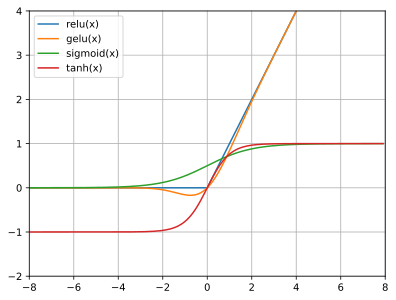

In [369]:
import torch
# from d2l import torch as d2l
import matplotlib.pyplot as plt
import torch.nn.functional as F

#ReLU
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
# d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))
plt.plot(x.detach(), y.detach(), label = "relu(x)")

y = F.gelu(x)
plt.plot(x.detach(), y.detach(), label = "gelu(x)")

y = torch.sigmoid(x)
# d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize = (5,2.5))
plt.plot(x.detach(), y.detach(), label = "sigmoid(x)")

y = torch.tanh(x)
# d2l.plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(5, 2.5))
plt.plot(x.detach(), y.detach(), label = "tanh(x)")

plt.legend()
plt.xlim(-8,8)
plt.ylim(-2,4)
plt.grid()
plt.show()

In [370]:
type(y)

torch.Tensor

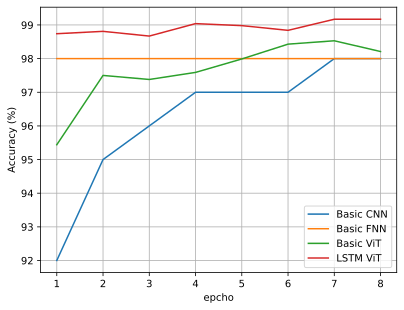

In [422]:
##
import matplotlib.pyplot as plt
import torch

fig = plt.figure()
x = torch.arange(8)+1

l1 = torch.tensor([92,95,96,97,97,97,98,98])
# l1 = [92,95,96,97,97,97,98,98].ToTensor
l2 = torch.tensor([98,98,98,98,98,98,98,98])
l3 = torch.tensor([95.44,97.50,97.38, 97.59,97.99,98.43,98.53,98.21])
l4 = torch.tensor([98.74, 98.81, 98.67, 99.04, 98.98, 98.84, 99.17, 99.17])


plt.plot(x, l1, label = "Basic CNN")
plt.plot(x, l2, label = "Basic FNN")
plt.plot(x, l3, label = "Basic ViT")
plt.plot(x, l4, label = "LSTM ViT")

plt.legend()
plt.grid()
plt.xlabel("epcho")
plt.ylabel("Accuracy (%)")
plt.show()